<a href="https://colab.research.google.com/github/flytanisha/102153037-SESS_LE1/blob/main/102153037_Tanisha_Maheshwary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Name: **Tanisha Maheshwary**  
#Email: `tmaheshwary_be21@thapar.edu`  
#Roll No: **102153037**  
#Group: **4CO28**  

## **Question**

  Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

#**1. Read and summarize**

The paper introduces the "Speech Commands" dataset, which is designed for improving keyword spotting and speech recognition. It contains 65,000 audio recordings from over 2,600 speakers, covering 12 different keywords. The dataset includes diverse speech samples from various environments and accents, making it useful for training models to recognize specific words in real-world conditions. It is openly available for research, helping researchers build and test their speech recognition systems more effectively.

#**2. Download the dataset in the paper, statistically analyse and describe it, so that it may be useful for posterity.**

In [3]:
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!wget -O dataset.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2024-09-12 15:33:58--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.12.207, 142.250.4.207, 172.253.118.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.12.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘dataset.tar.gz’

dataset.tar.gz      100%[===================>]   2.26G  23.6MB/s    in 1m 43s  

2024-09-12 15:35:42 (22.5 MB/s) - ‘dataset.tar.gz’ saved [2428923189/2428923189]



In [5]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:
import os
import tarfile
import numpy as np
import tensorflow as tf  # Import TensorFlow

tar_file_path = 'dataset.tar.gz'  # Replace with the path to your tar.gz file
extracted_dir = 'speech_commands_dataset1'  # Directory to extract to

# Check if the directory already exists to avoid re-extracting
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)  # Create the directory if it doesn't exist
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(extracted_dir)
        print(f"Extracted to {extracted_dir}")

# List the contents of the extracted folder
commands = np.array(tf.io.gfile.listdir(extracted_dir))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'background_noise')]

print('Commands:', commands)


Extracted to speech_commands_dataset1
Commands: ['forward' 'right' 'yes' 'no' 'left' 'off' 'happy' 'learn' 'four' 'sheila'
 'marvin' 'six' 'stop' 'nine' 'LICENSE' 'tree' 'two' 'up' 'dog' 'on' 'go'
 'one' 'validation_list.txt' 'down' 'follow' 'eight' 'three' 'zero'
 '_background_noise_' 'testing_list.txt' 'bird' 'seven' 'backward' 'house'
 'five' 'cat' 'wow' 'bed' 'visual']


In [7]:
data_dir = extracted_dir

# Load dataset
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print("Label names:", label_names)


Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.
Label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [8]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


In [9]:
for example_audio, example_labels in train_ds.take(1):
    print("Example Audio Shape:", example_audio.shape)
    print("Example Labels Shape:", example_labels.shape)



Example Audio Shape: (64, 16000)
Example Labels Shape: (64,)


# **Visualization**

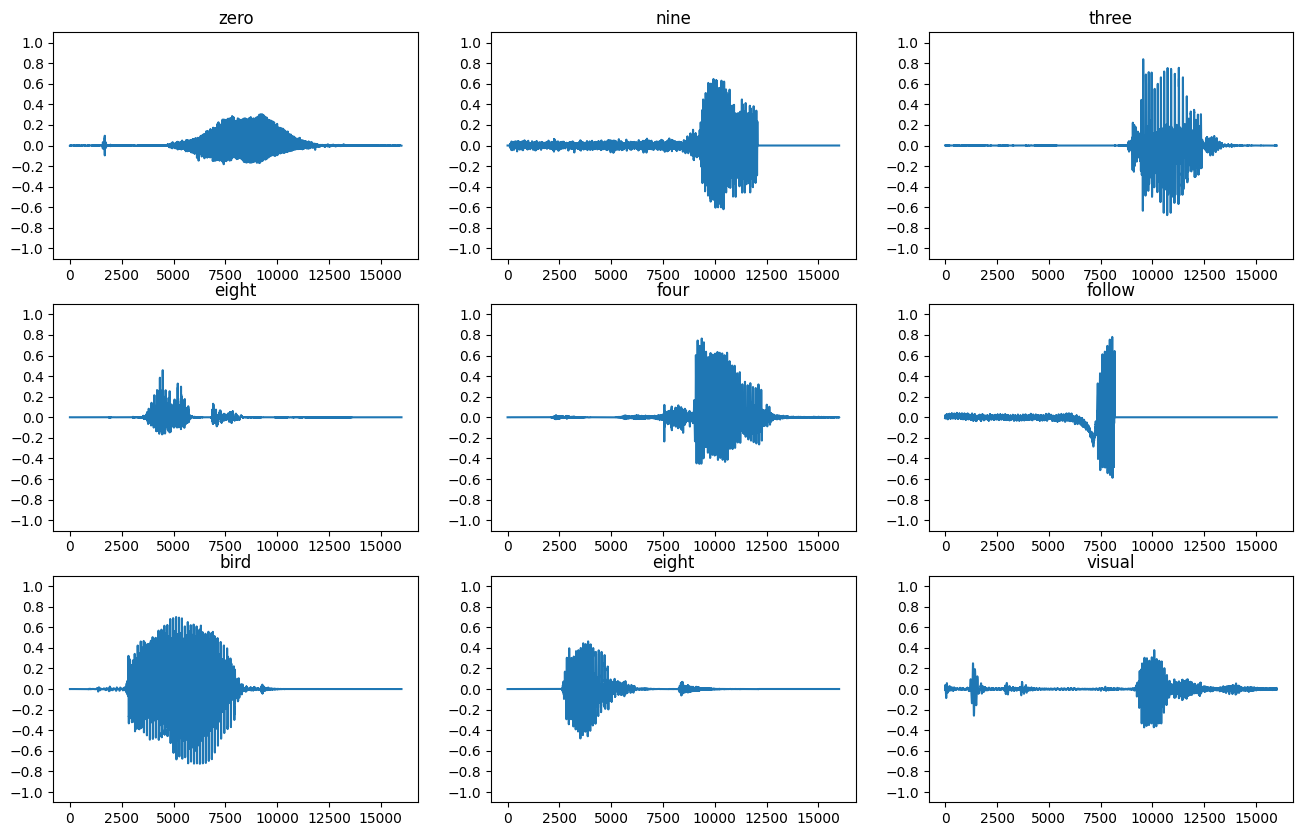

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()


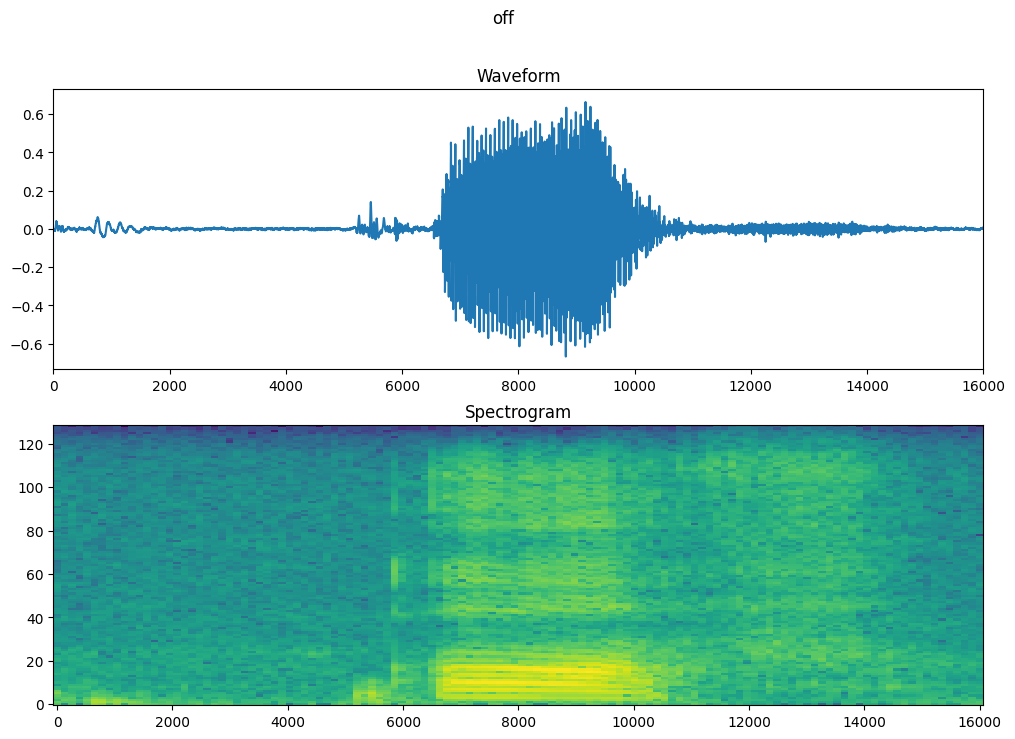

In [11]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension.
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

# Plot the waveform and its spectrogram
for example_audio, example_labels in train_ds.take(1):
    waveform = example_audio[0]
    spectrogram = get_spectrogram(waveform)

    fig, axes = plt.subplots(2, figsize=(12, 8))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy())
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, 16000])

    plot_spectrogram(spectrogram.numpy(), axes[1])
    axes[1].set_title('Spectrogram')
    plt.suptitle(label_names[example_labels[0].numpy()])
    plt.show()


In [12]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: off
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: four
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: eight
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


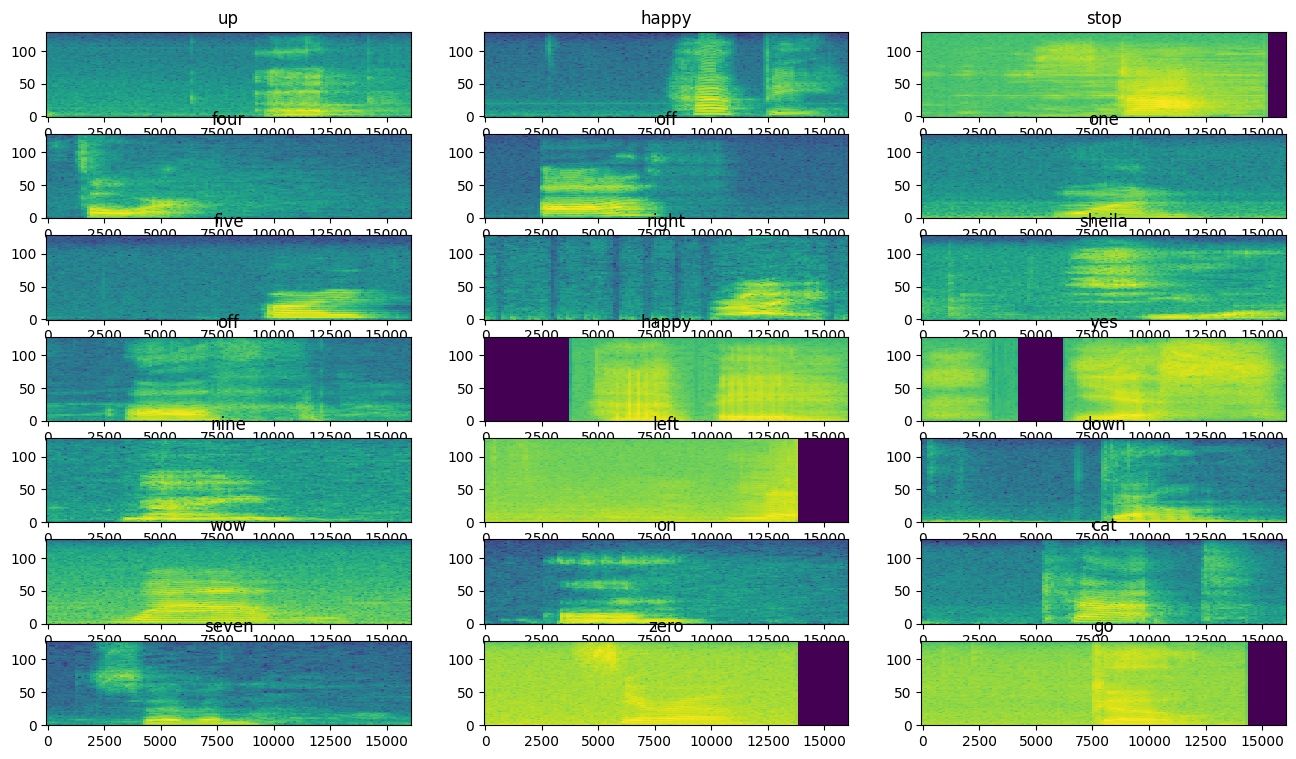

In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 7
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# **3. Train a classifier so that you are able to distinguish the commands in the dataset.**

In [14]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [15]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input to 40x40 for a balance between speed and detail
    layers.Resizing(40, 40),
    # Normalize.
    norm_layer,

    # First Conv2D layer with slightly more filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),  # Add batch normalization for stability
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Conv2D layer with more filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Global average pooling to reduce the number of parameters
    layers.GlobalAveragePooling2D(),

    # Slightly larger dense layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Slightly increased dropout to reduce overfitting

    # Output layer
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 40, 40, 1)         0         
                                                                 
 normalization (Normalizati  (None, 40, 40, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 40, 40, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 32)        0         
 D)                                                              
                             

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# **4. Report the performance results using standard benchmarks.**

In [17]:
EPOCHS = 2
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1323/1323 [==============================] - 57s 38ms/step - loss: 2.1087 - accuracy: 0.4081 - val_loss: 1.3890 - val_accuracy: 0.5930
Epoch 2/2
1323/1323 [==============================] - 10s 7ms/step - loss: 1.1617 - accuracy: 0.6608 - val_loss: 1.0264 - val_accuracy: 0.7034


Text(0, 0.5, 'Accuracy [%]')

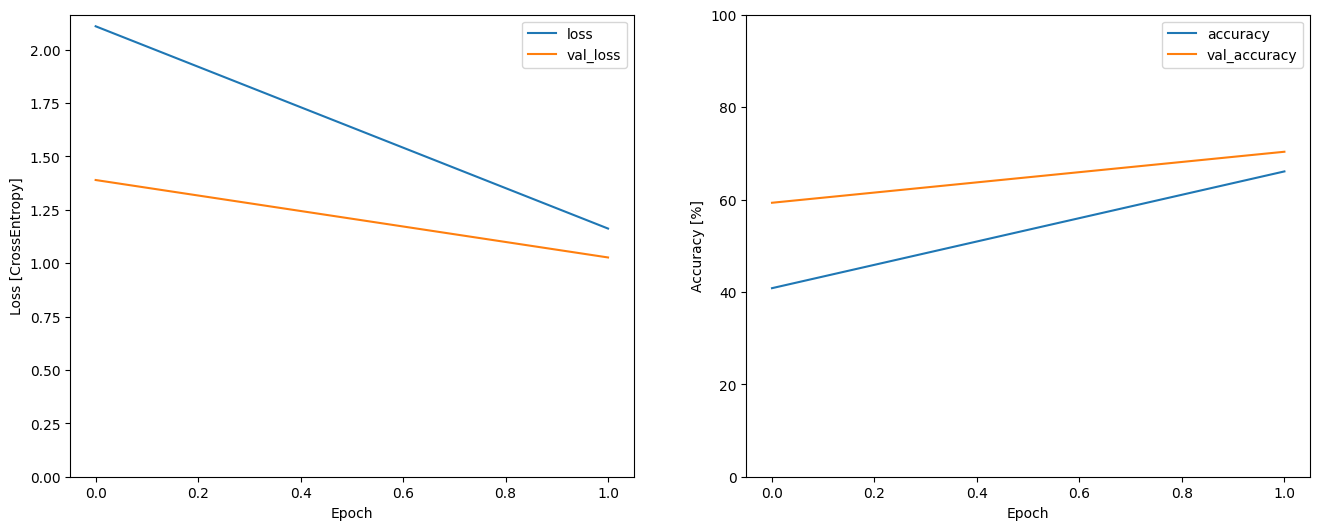

In [18]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# **Fine tuning**


# **5. Record about 30 samples of each command in your voice and create a new dataset (including a new user id for yourself). You may use a timer on your computer to synchronise.**


# **6. Fine tune your classifier to perform on your voice.**

In [20]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [22]:
import pydub
from pydub import AudioSegment
import os

# Path to the folder where the recordings are stored
input_folder = '/content/drive/MyDrive/Speech_Recognition/recordings/'

# Path to the folder where you want to save the split recordings
output_base_folder = '/content/drive/MyDrive/Speech_Recognition/split_recordings/'

# Make sure the output folder exists
os.makedirs(output_base_folder, exist_ok=True)

# List all the audio files in the input folder
audio_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]

# Split each audio file into 1-second segments
for file_name in audio_files:
    # Load the audio file
    audio_path = os.path.join(input_folder, file_name)
    audio = AudioSegment.from_wav(audio_path)

    # Create a folder to store the 1-second segments
    new_folder_name = file_name.replace('.wav', '_1sec')
    output_folder = os.path.join(output_base_folder, new_folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Split the 30-second file into 1-second segments
    segment_duration = 1000  # 1000 milliseconds = 1 second
    for i in range(30):
        start_time = i * segment_duration
        end_time = (i + 1) * segment_duration
        segment = audio[start_time:end_time]

        # Save the segment to the new folder
        segment_file_name = f'{new_folder_name}_{i+1}.wav'
        segment_path = os.path.join(output_folder, segment_file_name)
        segment.export(segment_path, format='wav')

    print(f'Saved 30 segments for {file_name} in {output_folder}')


Saved 30 segments for zero.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/zero_1sec
Saved 30 segments for one.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/one_1sec
Saved 30 segments for two.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/two_1sec
Saved 30 segments for three.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/three_1sec
Saved 30 segments for four.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/four_1sec
Saved 30 segments for five.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/five_1sec
Saved 30 segments for six.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/six_1sec
Saved 30 segments for seven.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/seven_1sec
Saved 30 segments for eight.wav in /content/drive/MyDrive/Speech_Recognition/split_recordings/eight_1sec
Saved 30 segments for nine.wav in /content/drive/MyDrive/Speech_Recogniti

In [23]:
# model training
EPOCHS = 3  # Increase this if you need more training

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    ]
)


Epoch 1/3
1323/1323 [==============================] - 10s 8ms/step - loss: 0.8874 - accuracy: 0.7378 - val_loss: 0.8766 - val_accuracy: 0.7396
Epoch 2/3
1323/1323 [==============================] - 10s 7ms/step - loss: 0.8217 - accuracy: 0.7586 - val_loss: 1.2291 - val_accuracy: 0.6657
Epoch 3/3
1323/1323 [==============================] - 10s 8ms/step - loss: 0.7811 - accuracy: 0.7678 - val_loss: 0.8031 - val_accuracy: 0.7656


# **7. Report the results.**

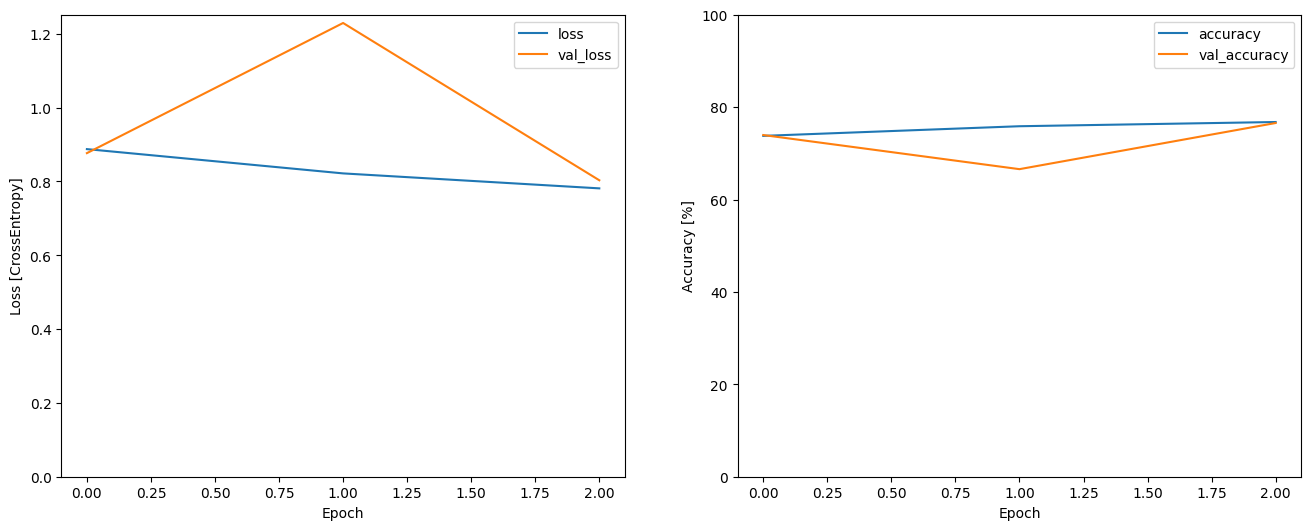

In [24]:
# visualize
metrics = history.history

plt.figure(figsize=(16,6))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], label='loss')
plt.plot(history.epoch, metrics['val_loss'], label='val_loss')
plt.legend()
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), label='accuracy')
plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), label='val_accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()


In [25]:
# testing
test_loss, test_acc = model.evaluate(test_spectrogram_ds)
print(f'Test accuracy: {test_acc * 100:.2f}%')


166/166 [==============================] - 29s 170ms/step - loss: 0.7782 - accuracy: 0.7748
Test accuracy: 77.48%
